https://github.com/ydataai/ydata-synthetic/blob/dev/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb

https://docs.nvidia.com/cuda/wsl-user-guide/index.html#getting-started-with-cuda-on-wsl

https://umap-learn.readthedocs.io/en/latest/index.html

In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

2022-02-24 08:35:55.497038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Specific to TimeGANs
# seq_len=24 # Original
seq_len=400
n_seq = 22
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [3]:
import pandas as pd

from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading

def transformations(path, seq_len: int):

    df = pd.read_csv(path)
    
    # Set centroid depth instead of from-to
    df["centroid_depth"] = df["Depth_From"] + (df["Depth_To"] - df["Depth_From"])/2

    processed_data = []

    # CSV can contain multiple holes which must be processed separately! DON'T CROSS THE STREAMS!
    df_grouped = df.groupby("Hole_ID")
    for _, g_df in df_grouped:
        try:
            g_df = g_df.set_index('centroid_depth').sort_index()
        except:
            g_df=g_df

        # Don't need the Hole_ID anymore
        g_df = g_df.drop(columns=["Hole_ID", "Depth_From", "Depth_To"])

        # Data transformations to be applied prior to be used with the synthesizer model
        processed_data.extend(real_data_loading(g_df.values, seq_len=seq_len))

    return processed_data

core_data = transformations(path='./data/MSDP_nozero.csv', seq_len=seq_len)
print(len(core_data),core_data[0].shape)

612 (400, 22)


In [4]:
if path.exists('synthesizer_core.pkl'):
    synth = TimeGAN.load('synthesizer_core.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(core_data, train_steps=500)
    synth.save('synthesizer_core.pkl')

2022-02-24 08:36:07.481256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-24 08:36:08.951279: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-24 08:36:08.951326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro T2000 with Max-Q Design computeCapability: 7.5
coreClock: 1.53GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 149.04GiB/s
2022-02-24 08:36:08.951361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-24 08:36:08.978970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-24 08:36:08.979051: I tensorflow/stream_e

In [6]:
synth_data = synth.sample(len(core_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

(640, 400, 22)


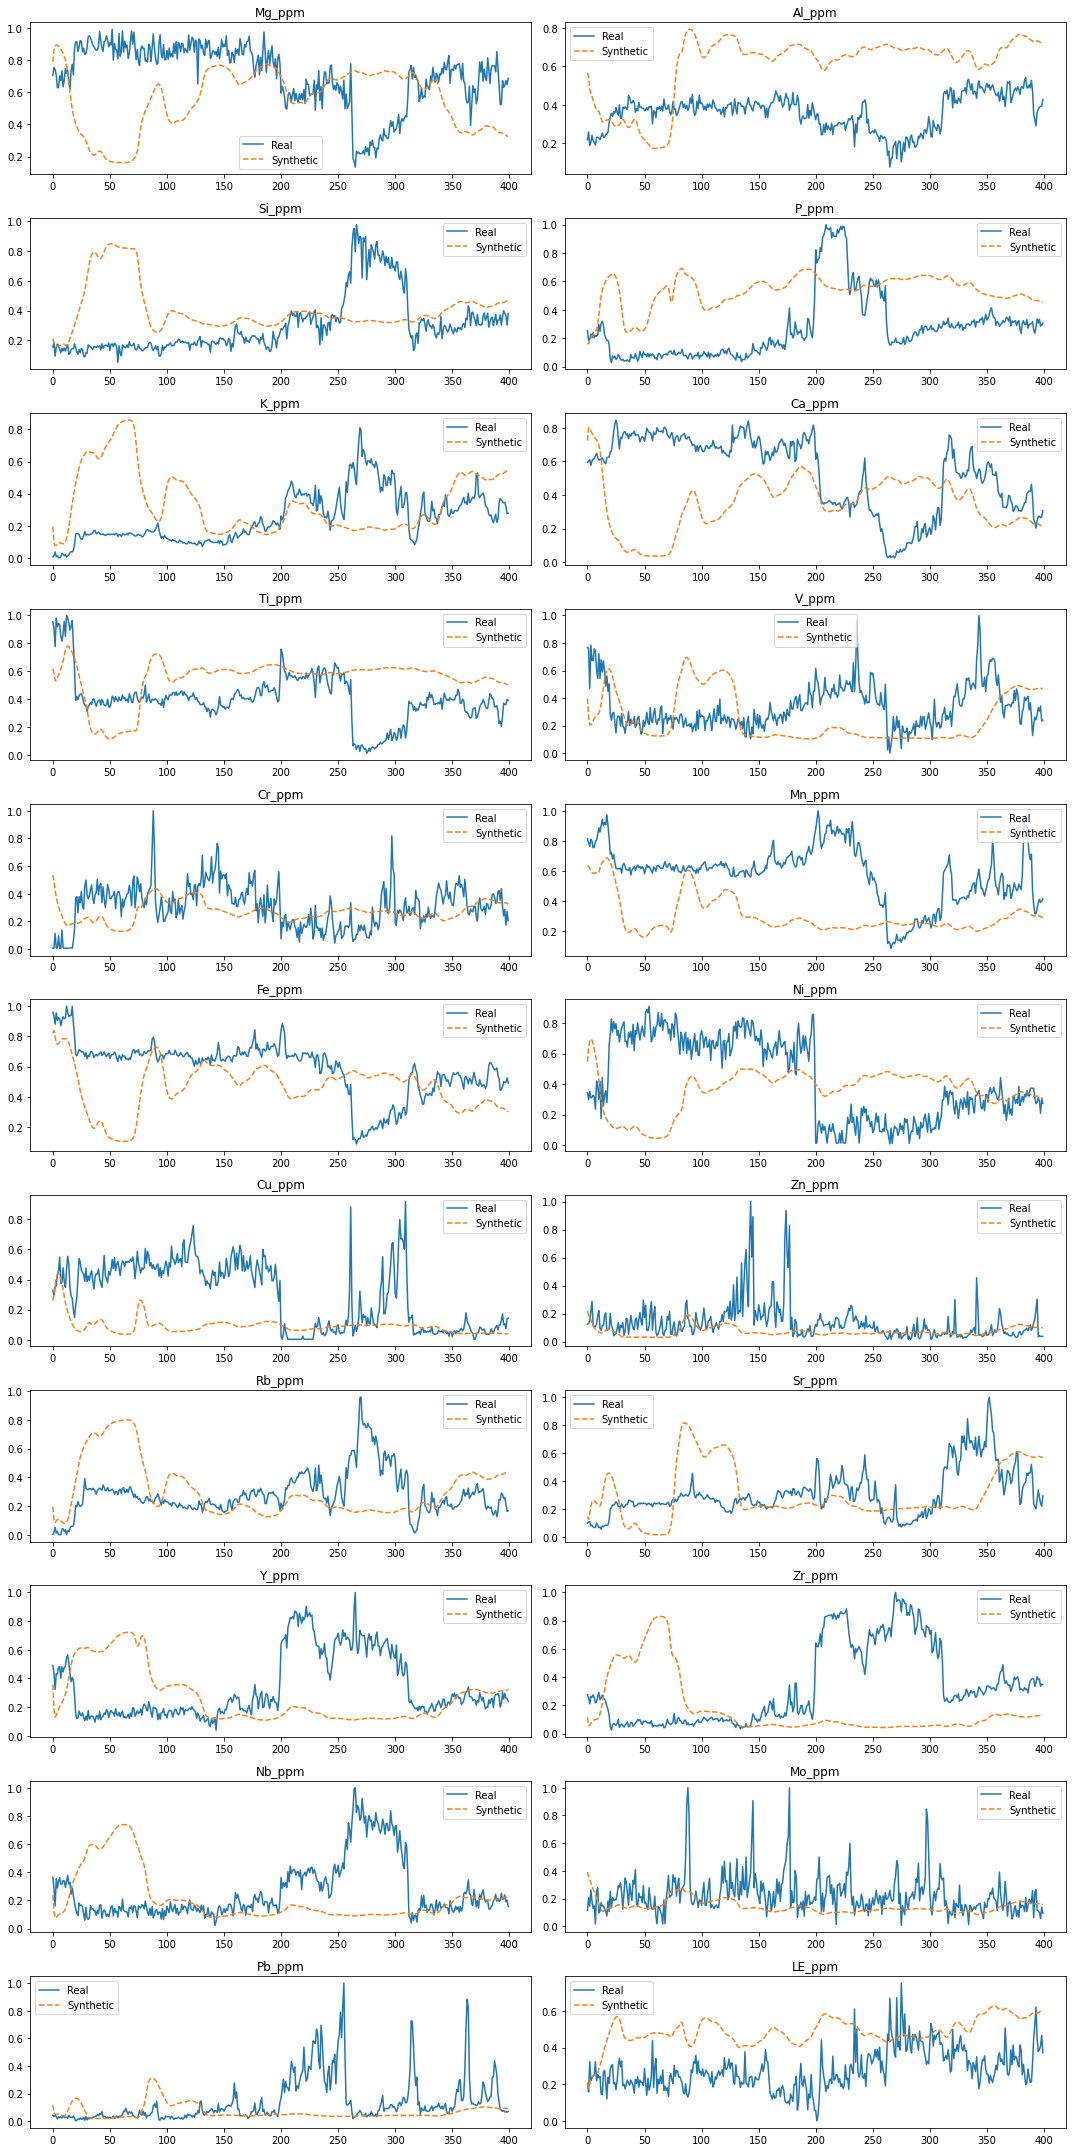

In [7]:
#Reshaping the data
cols = ['Mg_ppm','Al_ppm','Si_ppm','P_ppm','K_ppm','Ca_ppm','Ti_ppm','V_ppm','Cr_ppm','Mn_ppm','Fe_ppm','Ni_ppm','Cu_ppm','Zn_ppm','Rb_ppm','Sr_ppm','Y_ppm','Zr_ppm','Nb_ppm','Mo_ppm','Pb_ppm','LE_ppm']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(15, 30))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(core_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': core_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(core_data))[:sample_size]

real_sample = np.asarray(core_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
core_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(core_data_reduced)

pca_real = pd.DataFrame(pca.transform(core_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((core_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/home/hun220/.cache/pypoetry/virtualenvs/drill-hole-gan-QTYml6m--py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hun220/.cache/pypoetry/virtualenvs/drill-hole-gan-QTYml6m--py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

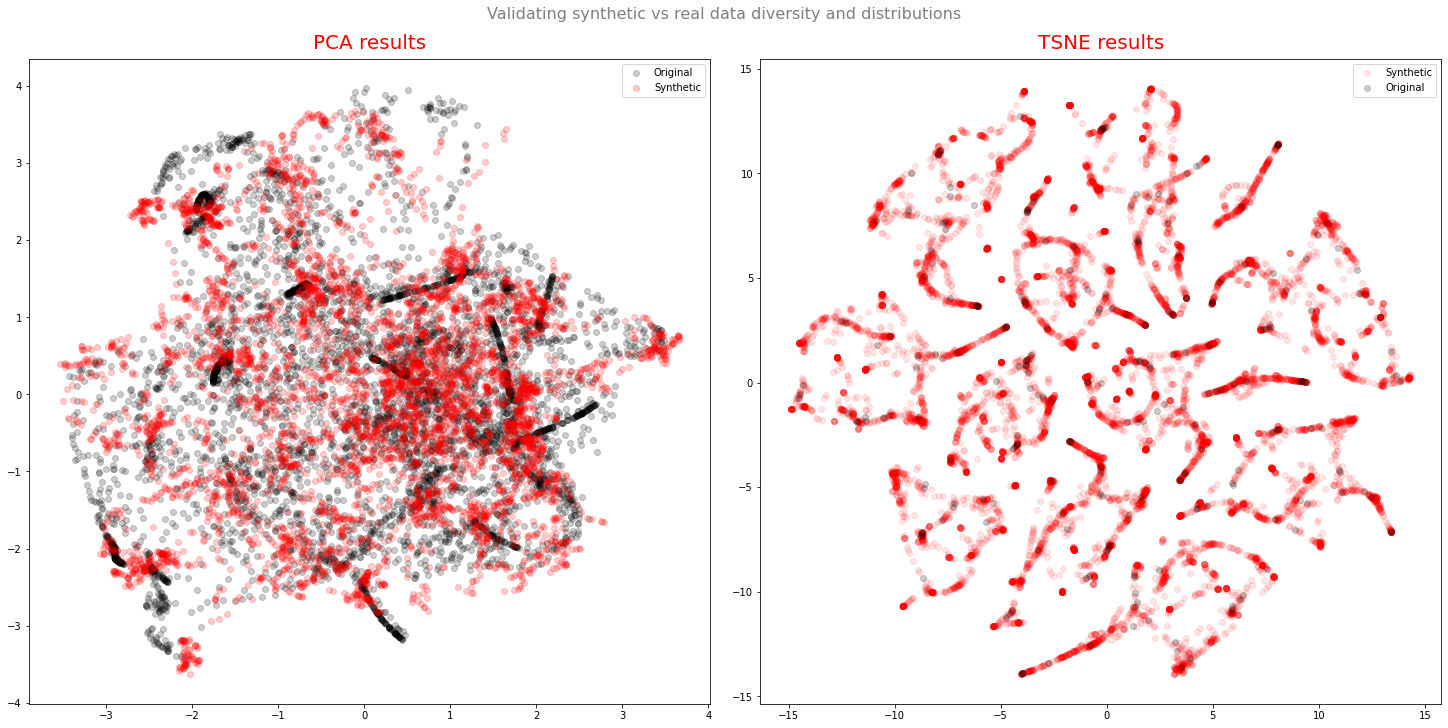

In [9]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.1, label='Synthetic')
plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')


ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [10]:
import umap
import umap.plot
# from sklearn.preprocessing import StandardScaler

# reducer = umap.UMAP(metric='correlation')
# scaled_core_data = StandardScaler().fit_transform(core_data_reduced)

mapper = umap.UMAP(metric='correlation', n_components=3).fit_transform(core_data_reduced)

In [11]:
# embedding = reducer.fit_transform(scaled_core_data)
# embedding.shape

# umap.plot.points(mapper, values=core_data_reduced.mean(axis=1), theme='fire')
# umap.plot.connectivity(mapper, show_points=True)
umap.plot.diagnostic(mapper, diagnostic_type='pca')

ValueError: Could not find embedding attribute of umap_object

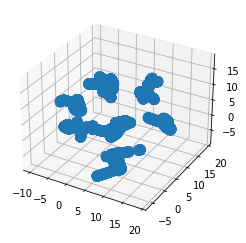

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    mapper[:, 0],
    mapper[:, 1],
    mapper[:, 2],
    # c=digits.target,
    cmap='Spectral',
    s=100)

In [13]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    # c=digits.target,
    cmap='Spectral',
    s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Drill Core dataset', fontsize=24)

NameError: name 'embedding' is not defined

<AxesSubplot:>

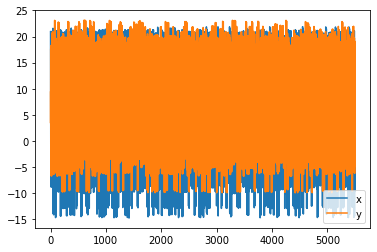

In [50]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df.plot()

<AxesSubplot:>

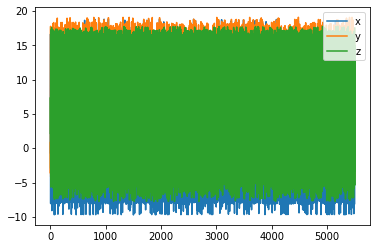

In [15]:
df_3d = pd.DataFrame(mapper, columns=('x', 'y', 'z'))
df_3d.plot()

In [16]:
import importlib
import plotly.express as px
importlib.reload(px)

# fig_3d = px.scatter_3d(
#     mapper, x=0, y=1, z=2,
#     # color=df.species, labels={'color': 'species'}
# )
# fig_3d.update_traces(marker_size=5)

# fig_3d.show()

fig = px.scatter_3d(df_3d, x='x', y='y', z='z')
fig.show()

In [17]:
from ydata_synthetic.synthesizers.timeseries import TimeGAN
synth = TimeGAN.load('synthesizer_core.pkl')
NO_SAMPLES = 300
synth_data = synth.sample(NO_SAMPLES)


Synthetic data generation: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


In [18]:
synth_data.shape

(384, 400, 22)

In [19]:
synth_data[:2, :, :1]

array([[[0.789232  ],
        [0.86620903],
        [0.88992506],
        [0.9018939 ],
        [0.90638644],
        [0.9077687 ],
        [0.90742964],
        [0.90589064],
        [0.9037624 ],
        [0.9014208 ],
        [0.89901584],
        [0.8966945 ],
        [0.89462346],
        [0.8929642 ],
        [0.89173234],
        [0.8908201 ],
        [0.8900974 ],
        [0.8894573 ],
        [0.88888097],
        [0.8883908 ],
        [0.8879963 ],
        [0.8876802 ],
        [0.8874047 ],
        [0.8871198 ],
        [0.8867817 ],
        [0.886373  ],
        [0.88589895],
        [0.88534224],
        [0.8846884 ],
        [0.8839996 ],
        [0.88333553],
        [0.882733  ],
        [0.8822363 ],
        [0.8818618 ],
        [0.8815739 ],
        [0.881346  ],
        [0.8811611 ],
        [0.8809985 ],
        [0.88088334],
        [0.880821  ],
        [0.8807873 ],
        [0.8807061 ],
        [0.8805039 ],
        [0.8802296 ],
        [0.87999016],
        [0

In [21]:
synth_data2 = np.reshape(synth_data, (synth_data.shape[0] * synth_data.shape[1], 22))
cols = ['Mg_ppm','Al_ppm','Si_ppm','P_ppm','K_ppm','Ca_ppm','Ti_ppm','V_ppm','Cr_ppm','Mn_ppm','Fe_ppm','Ni_ppm','Cu_ppm','Zn_ppm','Rb_ppm','Sr_ppm','Y_ppm','Zr_ppm','Nb_ppm','Mo_ppm','Pb_ppm','LE_ppm']
sd_df = pd.DataFrame(synth_data2, columns=cols)


<AxesSubplot:>

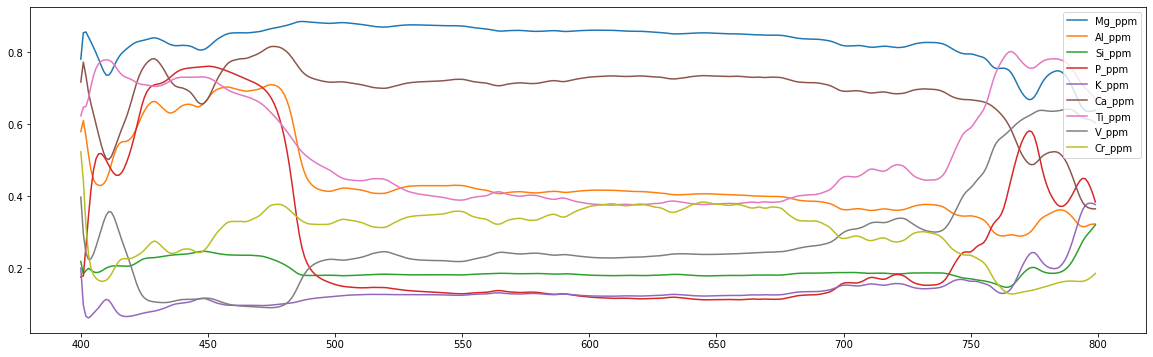

In [24]:
sd_df[400:800][['Mg_ppm','Al_ppm','Si_ppm','P_ppm','K_ppm','Ca_ppm','Ti_ppm','V_ppm','Cr_ppm']].plot(figsize=(20,6))

<AxesSubplot:>

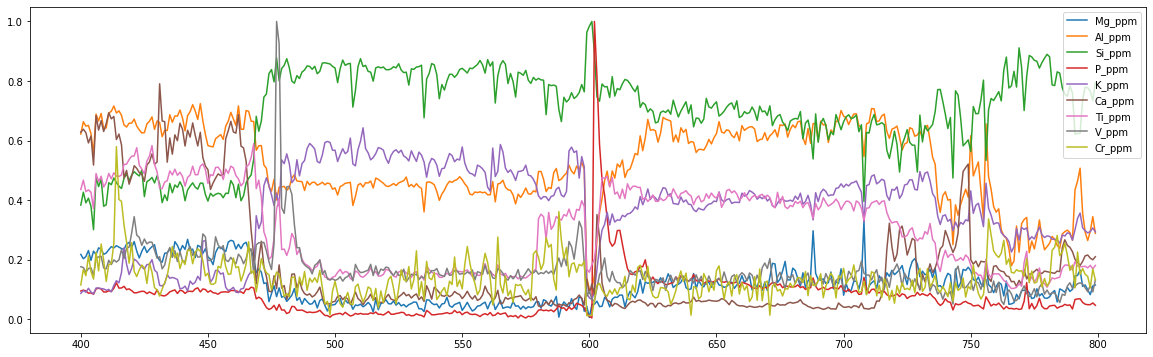

In [25]:
real_df = pd.read_csv('./data/MSDP_nozero.csv')
real_df = real_df[['Mg_ppm','Al_ppm','Si_ppm','P_ppm','K_ppm','Ca_ppm','Ti_ppm','V_ppm','Cr_ppm']]
normalized_df=(real_df-real_df.min())/(real_df.max()-real_df.min())
normalized_df[400:800][['Mg_ppm','Al_ppm','Si_ppm','P_ppm','K_ppm','Ca_ppm','Ti_ppm','V_ppm','Cr_ppm']].plot(figsize=(20,6))
